# Content


### 1. [Map Reduce](#1-map-reduce)

### 2. [Short Term vs Long Term Memory](#2-short-term-vs-long-term-memory)

### 3. ...


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


<a id="#1-map-reduce"></a>
# 1. Map Reduce

### Map

- This involves breaking a task into smaller sub-tasks, processing each sub-task in parallel.

### Reduce

-  This involves combining/aggregating the results of the completed, parallelized sub-tasks.

In [4]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [5]:
# Prompts
from langchain_core.language_models.chat_models import BaseChatModel


subject_prompt: str = """
<instruction>
Generate a list of 3 sub-topics that are all 
related to this overall topic: {topic!r} 
</instruction>
"""

joke_prompt: str = "<instruction>Generate a joke about {subject!r}.</instruction>"
best_joke_prompt: str = """
<instruction>
Below are a bunch of jokes about {topic!r}. Select the best one! Return the ID 
of the best one, starting 0 as the ID for the first joke. Jokes: \n\n{jokes}
</instruction>
"""

model_str: str = "mistralai:open-mixtral-8x22b"
llm: BaseChatModel = init_chat_model(model=model_str, temperature=0.0)

## Parallelizing Joke Generation

- Define a graph that will:
  - take a user input topic
  - produce a list of joke topics fro it
  - send each joke topic to the LLM
- The state has a `jokes` key that will accumulate jokes from parallelized joke generations.

In [6]:
from pydantic import BaseModel, Field


class Subjects(BaseModel):
    subjects: list[str] = Field(description="List of subjects related to the topic.")


class BestJoke(BaseModel):
    id: int = Field(description="ID of the best joke selected from the list of jokes.")


class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list[str], add_messages]
    best_selected_joke: str

#### Test The Code

In [7]:
# OverallState(
#     topic="Chinedu",
#     subjects=["love", "work"],
#     jokes=[],
#     best_selected_joke="",
# )
prompt: str = subject_prompt.format(topic="animals")
print(prompt)

response = await llm.with_structured_output(Subjects).ainvoke(prompt)
print(response)


<instruction>
Generate a list of 3 sub-topics that are all 
related to this overall topic: 'animals' 
</instruction>

subjects=['mammals', 'reptiles', 'birds']


In [8]:
async def generate_topics(state: OverallState) -> dict[str, Any]:
    """Generate a list of subjects based on a given topic.

    Parameters:
        state (OverallState): The current state containing the topic to generate subjects for.
            Expected to have a 'topic' key with a string value.

    Returns:
        dict[str, Any]

    Notes:
        Uses an LLM to generate structured output in the form of Subjects.
    """
    prompt: str = subject_prompt.format(topic=state["topic"])
    response: Subjects = await llm.with_structured_output(Subjects).ainvoke(prompt)
    return {"subjects": response.subjects}

### Send Function

- In LangGraph, Nodes and Edges usually share a predefined state. However, for dynamic cases like map-reduce, LangGraph uses `Send` objects in conditional edges.
- It can be used to parallelize tasks.

In [9]:
from langgraph.constants import Send


def continue_to_jokes(state: OverallState) -> list[Send]:
    """
    Generate N number of jokes in parallel by sending them to the required nodes.

    Parameters
    ----------
    state : OverallState
        The current state containing subjects for joke generation.

    Returns
    -------
    list[Send]
    """
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str


async def generate_joke(state: JokeState) -> dict[str, Any]:
    prompt: str = joke_prompt.format(subject=state["subject"])
    response = await llm.with_structured_output(Joke).ainvoke(prompt)
    return {"jokes": [response.joke]}


async def select_best_joke(state: OverallState) -> dict[str, Any]:
    """
    Select the best joke from a list of jokes based on a given topic.
    This is a reduction step.

    Parameters
    ----------
    state : OverallState
        The current state containing jokes and topic for selection.
        Expected keys:
            - jokes: list[str | HumanMessage]
            - topic: str

    Returns
    -------
    dict[str, Any]
        Dictionary containing the best selected joke.
        Keys:
            - best_selected_joke: str
    """
    if isinstance(state["jokes"][0], HumanMessage):
        state["jokes"] = [j.content for j in state["jokes"]]
    jokes: str = "\n\n".join(state["jokes"])
    prompt: str = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = await llm.with_structured_output(BestJoke).ainvoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [10]:
async def generate_joke(state: JokeState) -> dict[str, Any]:
    prompt: str = joke_prompt.format(subject=state["subject"])
    response = await llm.with_structured_output(Joke).ainvoke(prompt)
    return {"jokes": [response.joke]}


await generate_joke(JokeState(subject="animals"))

{'jokes': ['Why dont some animals play cards in the wild? Because theres too much cheetahs!']}

In [11]:
_jokes: list[str] = [
    "Why do seagulls fly over the sea?",
    "Why dont mammals ever get locked out of their homes? Because "
    "they always carry their keys with them!",
    "Why dont reptiles ever forget? Because no one ever lizard them a thing!",
]

jokes: str = "\n\n".join(_jokes)
prompt: str = best_joke_prompt.format(topic="animals", jokes=jokes)
print(prompt)
resp = await llm.with_structured_output(BestJoke).ainvoke(prompt)
print(resp.id)
result = {"best_selected_joke": _jokes[resp.id]}
print(f"{result = }")


<instruction>
Below are a bunch of jokes about 'animals'. Select the best one! Return the ID 
of the best one, starting 0 as the ID for the first joke. Jokes: 

Why do seagulls fly over the sea?

Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!

Why dont reptiles ever forget? Because no one ever lizard them a thing!
</instruction>

1
result = {'best_selected_joke': 'Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!'}


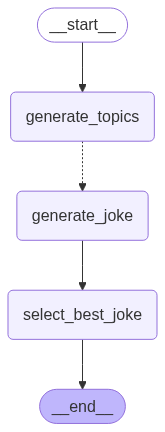

In [12]:
graph_builder = StateGraph(OverallState)

# Add nodes
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_node("select_best_joke", select_best_joke)

# Add edges
graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges(
    "generate_topics",
    # Generate jokes in parallel by `Sending` the jokes the `generate_joke` node
    continue_to_jokes,
    ["generate_joke"],
)
graph_builder.add_edge("generate_joke", "select_best_joke")
graph_builder.add_edge("select_best_joke", END)

# Compile the graph
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

<br>

### Test The Graph

In [13]:
topic: str = "animals"

async for s in graph.astream({"topic": topic}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'reptiles', 'birds']}}
{'generate_joke': {'jokes': ['Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!']}}
{'generate_joke': {'jokes': ['Why do seagulls fly over the sea?']}}
{'generate_joke': {'jokes': ['Why dont reptiles ever forget? Because no one ever lizard them a thing!']}}
{'select_best_joke': {'best_selected_joke': 'Why dont mammals ever get locked out of their homes? Because they always carry their keys with them!'}}


<a id="2-short-term-vs-long-term-memory"></a>
# Short Term vs Long Term Memory